In [2]:
% matplotlib inline

UsageError: Line magic function `%` not found.



# Comparing different clustering algorithms on toy datasets

This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.


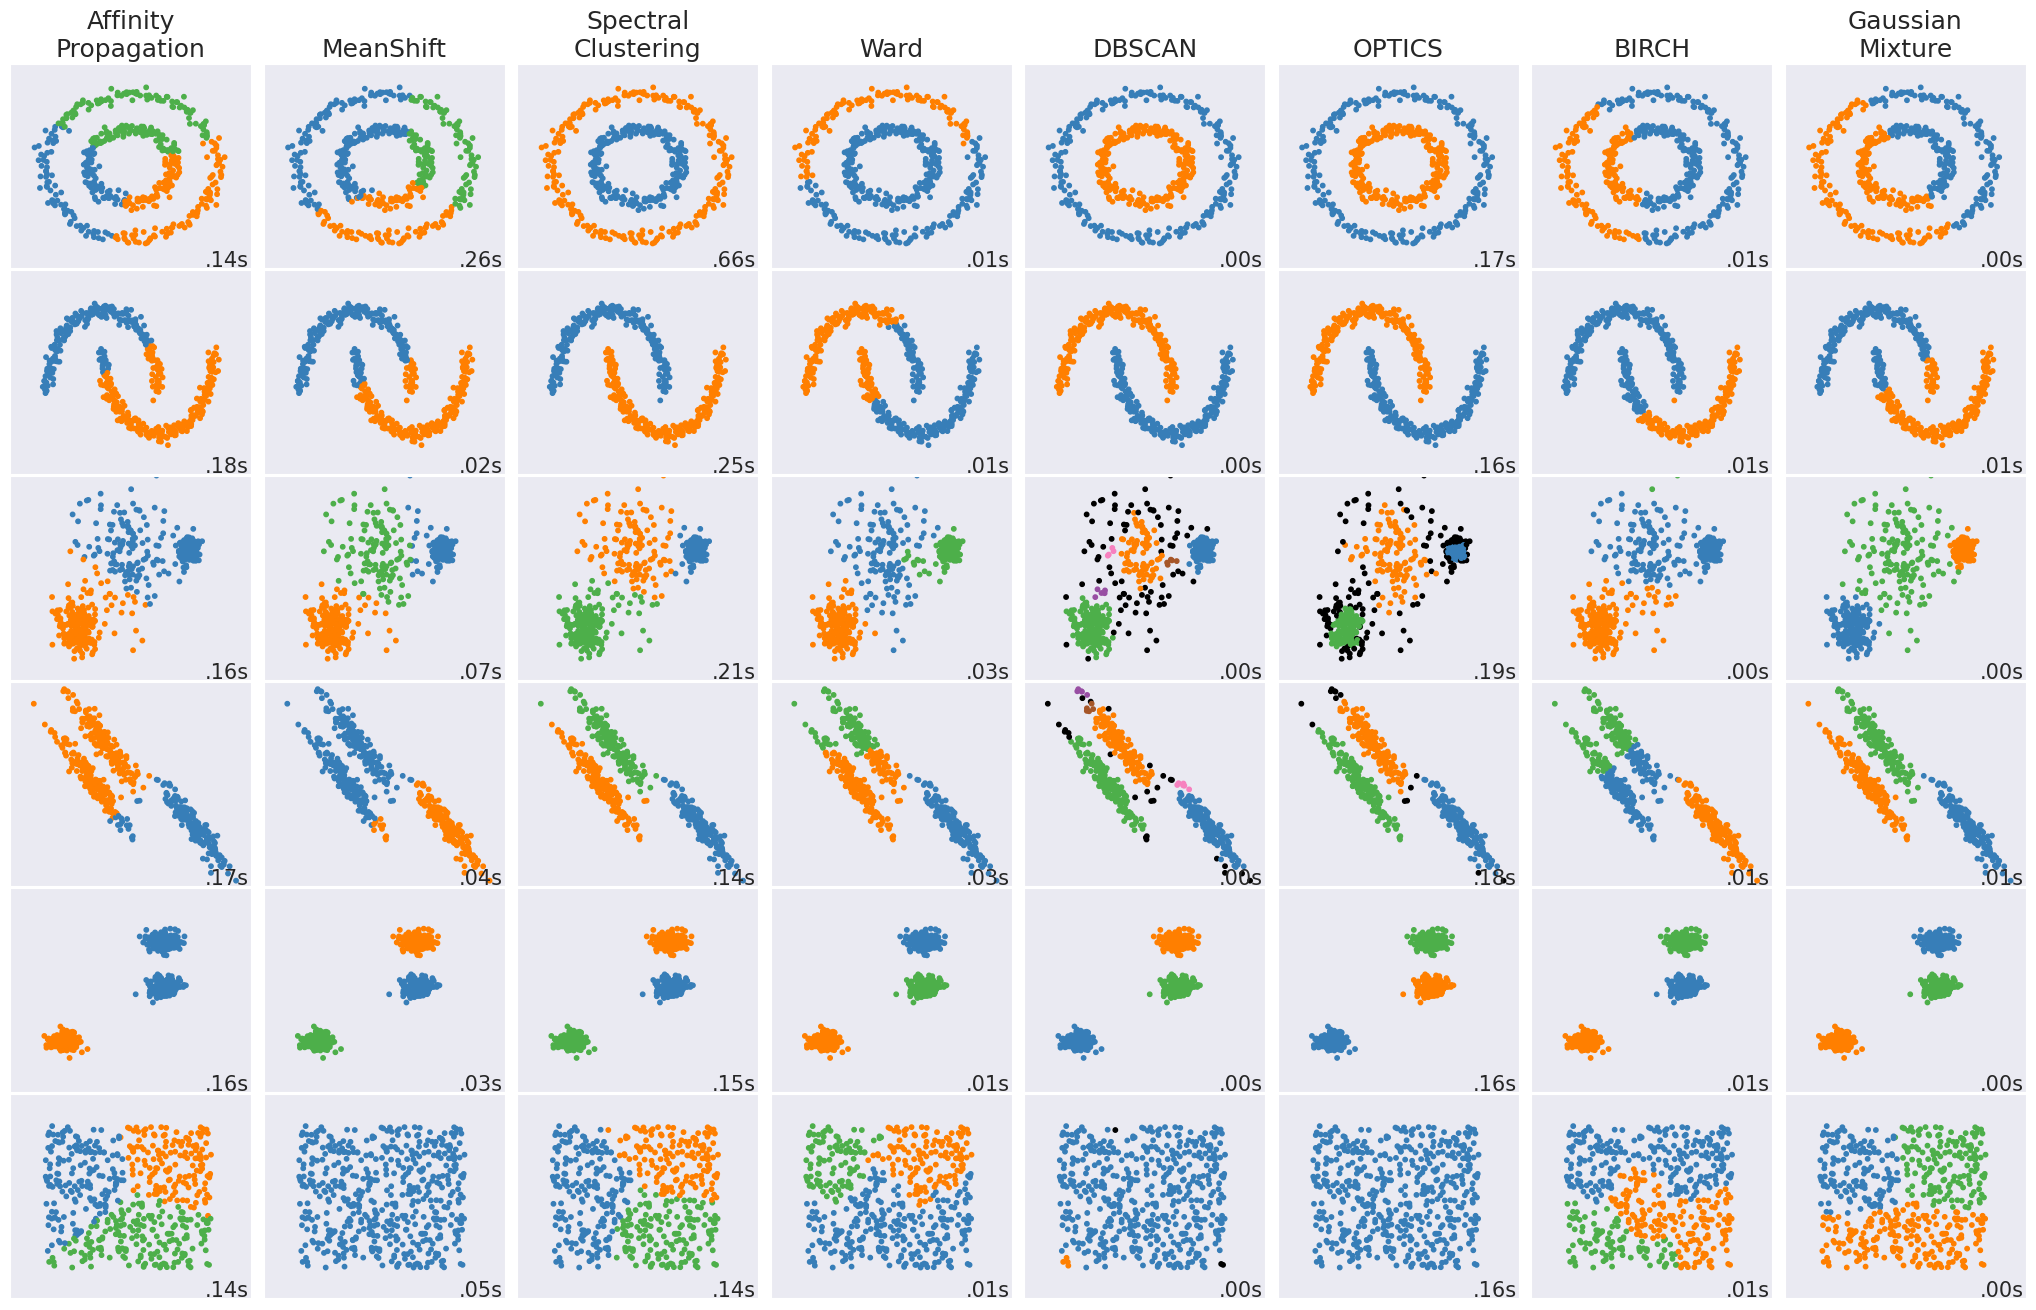

In [3]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import ClusterEnsembles as CE
from sklearn.metrics import normalized_mutual_info_score

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)
# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

datasets_copy = datasets.copy()
y_pred_list_for_all_datasets = []

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )

    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    y_pred_list_for_single_dataset = []

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                        + "connectivity matrix is [0-9]{1,2}"
                        + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                        + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)
        y_pred_list_for_single_dataset.append(y_pred)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1
    y_pred_list_for_all_datasets.append(y_pred_list_for_single_dataset)

plt.show()

k_clusters = []
for element in y_pred_list_for_all_datasets:
    clusters_number = []
    for cluster in element:
        k = len(np.unique(cluster))
        clusters_number.append(k)
    k_clusters.append(clusters_number)

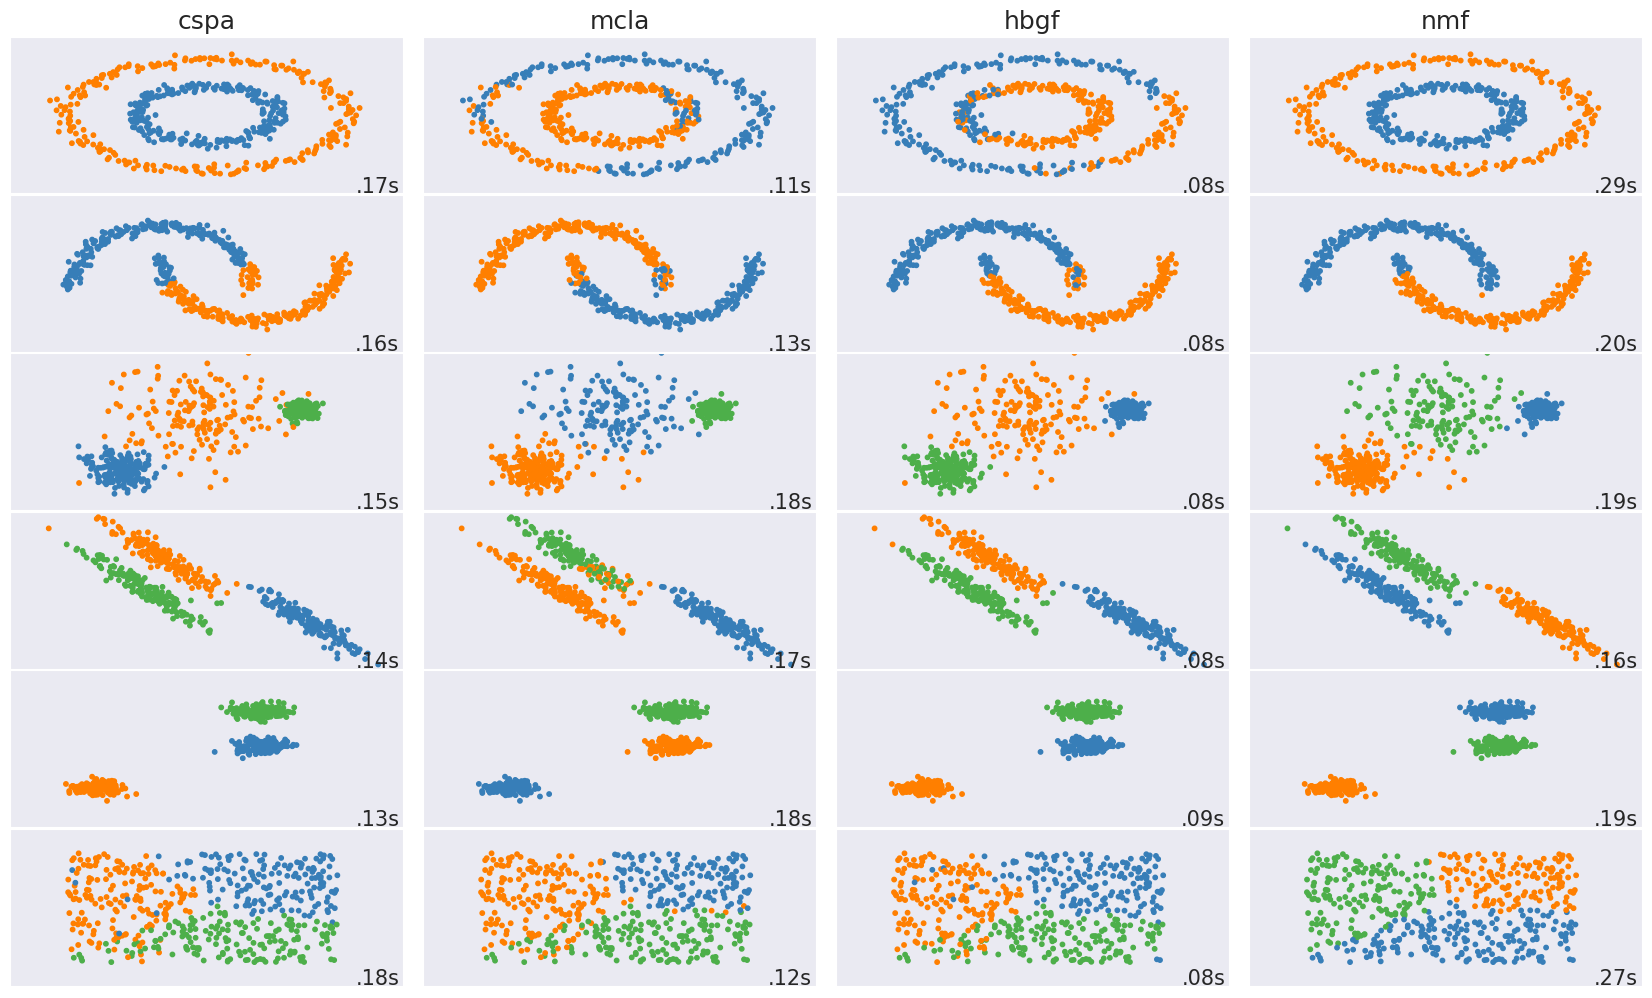

[1.0, 0.3241472446352001, 0.3232636772490691, 1.0]
[1.0, 0.6992277651852459, 0.7399050314423042, 0.7849535781248631]
[0.9605371417039688, 0.9185448108371049, 0.9494742671687607, 0.9270432613768319]
[1.0, 0.9391894422146473, 0.9666082369199468, 1.0]
[1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0]


In [4]:
clustering_ensembles_algorithms = ['cspa', 'mcla', 'hbgf', 'nmf']
plt.figure(figsize=(7 * 2 + 3, 10))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1


nmi_score_list = []
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    for i, liste in enumerate(y_pred_list_for_all_datasets):
        if i == i_dataset:
            nmi_score_for_row =[]
            for algo in clustering_ensembles_algorithms:
                nmi_score_old = 0
                best_clustering = None
                for index,k in enumerate(k_clusters[i]):
                    label_true = y_pred_list_for_all_datasets[i][index]
                    t0 = time.time()
                    label_pred = CE.cluster_ensembles(np.array(liste), nclass=k, solver=algo)
                    t1 = time.time()
                    nmi_score = normalized_mutual_info_score(label_true, label_pred, average_method='geometric')
                    if nmi_score > nmi_score_old:
                        nmi_score_old = nmi_score
                        best_clustering = label_pred
                nmi_score_for_row.append(nmi_score_old)
                plt.subplot(len(datasets), len(clustering_ensembles_algorithms), plot_num)
                if i_dataset == 0:
                    plt.title(algo, size=18)

                colors = np.array(
                    list(
                        islice(
                            cycle(
                                [
                                    "#377eb8",
                                    "#ff7f00",
                                    "#4daf4a",
                                    "#f781bf",
                                    "#a65628",
                                    "#984ea3",
                                    "#999999",
                                    "#e41a1c",
                                    "#dede00",
                                ]
                            ),
                            int(max(label_pred) + 1),
                        )
                    )
                )
                # add black color for outliers (if any)
                #colors = np.append(colors, ["#000000"])
                plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[label_pred])
                plt.xlim(-2.5, 2.5)
                plt.ylim(-2.5, 2.5)
                plt.xticks(())
                plt.yticks(())
                plt.text(
                    0.99,
                    0.01,
                    ("%.2fs" % (t1 - t0)).lstrip("0"),
                    transform=plt.gca().transAxes,
                    size=15,
                    horizontalalignment="right",
                )
                plot_num += 1
            nmi_score_list.append(nmi_score_for_row)
plt.show()
for item in nmi_score_list:
    print(item)

Automatically created module for IPython interactive environment


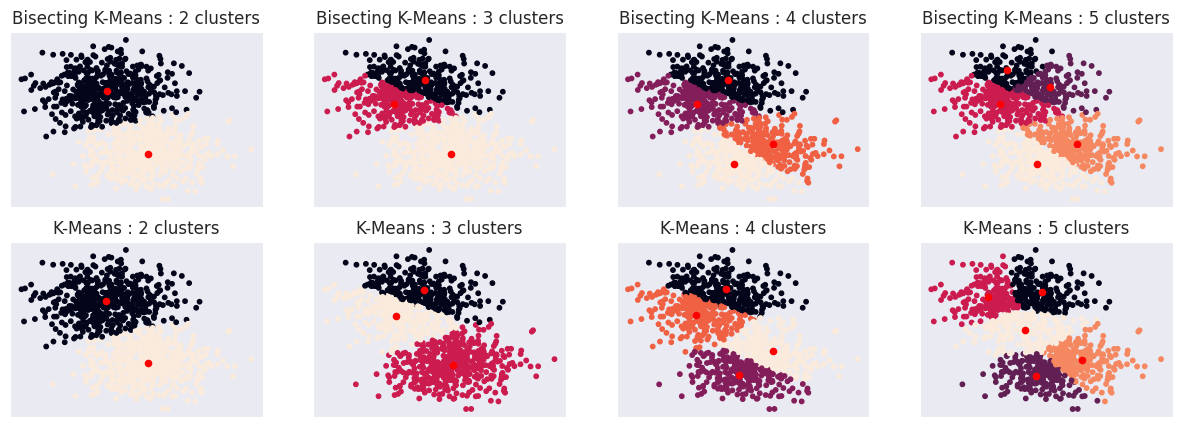

In [5]:
from sklearn.datasets import make_blobs
from sklearn.cluster import BisectingKMeans, KMeans

print(__doc__)

# Generate sample data
n_samples = 1000
random_state = 0

X, _ = make_blobs(n_samples=n_samples, centers=2, random_state=random_state)

# Number of cluster centers for KMeans and BisectingKMeans
n_clusters_list = [2, 3, 4, 5]

# Algorithms to compare
clustering_algorithms = {
    "Bisecting K-Means": BisectingKMeans,
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(15, 5)
)

axs = axs.T

kmeans_output = []
for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, random_state=random_state, n_init=3)
        algo.fit(X)
        centers = algo.cluster_centers_
        if algorithm_name == "K-Means":
            kmeans_output.append(algo.labels_)
        axs[j, i].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
        axs[j, i].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j, i].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])


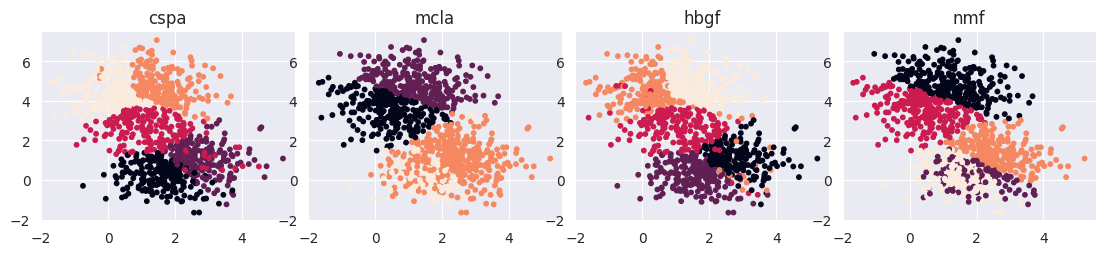

[0.9467876343941266, 0.955770920757279, 0.9348473984310677, 0.9075210451016509]

In [6]:
plt.figure(figsize=(4 * 2 + 3, 2))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1
kmeans_output_clustering = np.array(kmeans_output)
nmi_score_list = []
for algo in clustering_ensembles_algorithms:
    plt.subplot(1, len(clustering_ensembles_algorithms), plot_num)
    best_clustering = None
    nmi_score_old = 0
    for i, k in enumerate(n_clusters_list):
        label_pred = CE.cluster_ensembles(kmeans_output_clustering, nclass=k, solver=algo)
        nmi_score = normalized_mutual_info_score(kmeans_output[i], label_pred, average_method='geometric')
        if nmi_score > nmi_score_old:
            nmi_score_old = nmi_score
            best_clustering = label_pred
    nmi_score_list.append(nmi_score_old)
    plt.scatter(X[:, 0], X[:, 1], s=10, c=label_pred)
    plt.title(f"{algo}")
    plot_num += 1

plt.show()
nmi_score_list